In [1]:
import numpy as np # library to handle data in a vectorized manner
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means and AffinityPropagation for clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AffinityPropagation
from sklearn import preprocessing
from sklearn import metrics
import folium # map rendering library
from folium.plugins import MarkerCluster
from folium import IFrame # To make pop/up labels
# Libraries which will help reading and working with geojson file as it would be regular pandas DF
import geopandas as gpd 
from geopandas import GeoDataFrame
import fiona
# These will help with spatial indexing
import osmnx as ox
ox.config(log_file=True, log_console=True, use_cache=True)
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPolygon
from pandas import read_excel
from bs4 import BeautifulSoup # for data scraping from webpage
# Thanks to these imports we can simply define the colors we want, and the index (thresholds) that correspond
import os
import branca
import branca.colormap as cm
from branca.element import Template, MacroElement # To make a legend
%matplotlib inline
print('Libraries imported.')

Libraries imported.


## Building the basic map with city districts

In [2]:
# downloading geojson file with 57 city districts coordinations
!wget --quiet http://opendata.iprpraha.cz/CUR/DTMP/TMMESTSKECASTI_P/WGS_84/TMMESTSKECASTI_P.json -O prg_districts.json

In [3]:
# checking the dataset with districts 
districts = gpd.read_file("prg_districts.json")
districts.head(2)

In [4]:
# Using "https://mapshaper.org/" to simplify above json file so that future map will load slightly quicker and storing new file to the github
!wget --quiet https://raw.githubusercontent.com/JakubVoros/Coursera_Capstone_The_Finale/master/prg_districts_2.json -O prg_districts_2.json

In [5]:
districts2 = gpd.read_file("prg_districts_2.json")
districts2.head(1)

,OBJECTID,DAT_VZNIK,DAT_ZMENA,PLOCHA,ID,KOD_MC,NAZEV_MC,KOD_MO,KOD_SO,TID_TMMESTSKECASTI_P,POSKYT,ID_POSKYT,STAV_ZMENA,NAZEV_1,Shape_Length,Shape_Area,geometry
0,1,20181106141412,20181106164427,10183715.85,25,547310,Praha-Čakovice,94,221,25,HMP-IPR,43,U,Čakovice,0.213162,1.018372e+07,"POLYGON ((14.56048437200008 50.15536430700007,..."


## Scrapping Informations about Rents

#### Getting needed data about rent from webpage and scraping it with BeautifulSoup


In [6]:
# average rent per m²/month
html_doc = requests.get('https://realitymix.centrum.cz/statistika-nemovitosti/byty-pronajem-prumerna-cena-pronajmu-1m2-mesic.html').text
soup = BeautifulSoup(html_doc, 'lxml')

In [7]:
# scraping necessary information and setting a new dataframe
table = soup.find('table',{'cellpadding':'0'})
column =[ 'District', '02/2018*m²', '12/2018*m²',  '01/2019*m²', '02/2019*m²']
rent = pd.DataFrame(columns = column)


#### Using loop to get all the informationt into the rent Dataframe

In [8]:
# Loopin over table rows (tr tag) and getting the text of cells (td tag)
# Cleaning texts from unnecessary signs ("\n") etc.
# Inserting everything into the dataframe

for tr in table.find_all('tr')[15:]:
    tds = tr.find_all('td')  
    d = tds[0].text
    uo = tds[1].text
    po = tds[2].text
    ld = tds[3].text
    ud = tds[4].text        
    rent = rent.append({'District' : d, '02/2018*m²': uo,
                                          '12/2018*m²': po, '01/2019*m²' : ld, '02/2019*m²': ud }, ignore_index=True)

In [9]:
rent.set_index("District",inplace=True)

In [10]:
# The average rent in area is based on municipal districts, each of those consists of city districts and with those we are working here.
rent = rent.astype('int')
rent = rent.transpose()
rent.to_csv('rent.csv')

In [128]:
rent = pd.read_csv('rent.csv', index_col = 'Unnamed: 0')
rent.head(4)

,Praha 1,Praha 2,Praha 3,Praha 4,Praha 5,Praha 6,Praha 7,Praha 8,Praha 9,Praha 10
02/2018*m²,418,399,346,291,346,302,327,307,289,281
12/2018*m²,443,394,364,289,351,316,333,312,282,299
01/2019*m²,439,392,353,287,349,314,334,314,293,300
02/2019*m²,443,395,352,287,352,311,329,325,295,300


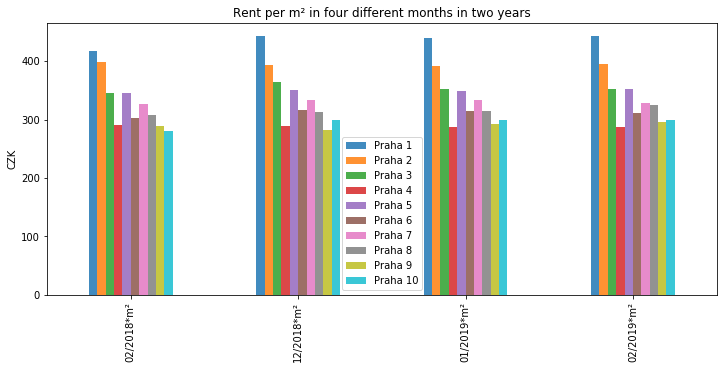

In [12]:
# Preview on average rents in ten municipal districts
rent.plot(kind="bar",alpha=0.85,figsize=(12,5), legend=True)
plt.title('Rent per m² in four different months in two years')
plt.ylabel('CZK')
plt.show()

### Second dataset with rents but now directly for those 57 districts

In [13]:
# There was one more dataset with rents and it is more thorough, because it's divided into those 57 city districts
!wget --quiet https://github.com/JakubVoros/Coursera_Capstone_The_Finale/blob/master/najmy_praha.xlsx?raw=true -O prg_rents.xlsx

In [14]:
rents_2 = pd.read_excel('prg_rents.xlsx')
rents_2.head(2)

,District,Rents_m²/CZK
0,Čakovice,160
1,Praha 14,160


In [15]:
#This will be used to do colormap and set its steps
rents_series = rents_2.set_index('District')['Rents_m²/CZK']
min1 = int(rents_series.min()) -10
max2 = int(rents_series.max()) +10
unique = len(rents_series.unique())


In [16]:
# Loading the geojson file, so we can add the data into our map
h = os.path.join('prg_districts_2.json')
geo_json_data = json.load(open(h))


In [17]:
# Exploring what are the most common rents so we can later on make them into steps, which will help distribute specific colour for each area(plus colormap)
vc = rents_series.value_counts()
print(vc)

145    8
165    8
155    6
200    4
175    4
160    4
135    2
140    2
210    2
170    2
150    2
215    2
205    1
190    1
95     1
185    1
100    1
110    1
430    1
240    1
180    1
120    1
225    1
Name: Rents_m²/CZK, dtype: int64


In [18]:
# Preparing steps and choosing colours. Each district will have specific colour beacuse of its average rent. 
i = [85,140,145,155,160,165,200,420,440]

step = cm.StepColormap(
    ['MediumSpringGreen','blue', '#ffff00','LawnGreen', 'gray', 'magenta', 'orange', 'red'],
    vmin=50, vmax=max2,
    index=i,
    caption='step'
)


In [20]:
# Getting latitude and longitude for Prague
address = 'Praha'

geolocator = Nominatim(user_agent="prague_move")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Prague are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Prague are 50.0874654, 14.4212535.


In [125]:
# This is our main map plotted with districts, coloured with average rents.
m = folium.Map(
    location=[latitude, longitude],
    tiles='cartodbpositron',
    zoom_start=11
)
folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor': step(rents_series[feature['properties']['NAZEV_1']]),
        'color': 'black',
        'weight': 2,
        'dashArray': '5, 5'
    },
    tooltip=folium.GeoJsonTooltip(fields=['NAZEV_1'],
                                    labels=False,
                                    sticky=False)
).add_to(m)

m

## Building a Dataset for Districts' Coordinations, Area/Radius which will be used for Foursquare

In [28]:
# Getting DF with names of 112 cadastral districts, so we can do thorough analysis with Foursquare and theirs area 
html_doc2 = requests.get('https://cs.wikipedia.org/wiki/Seznam_katastr%C3%A1ln%C3%ADch_%C3%BAzem%C3%AD_Prahy_podle_po%C4%8Dtu_obyvatel').text
soup2 = BeautifulSoup(html_doc2, 'lxml')

In [34]:
# Setting new DF
table2 = soup2.find('tbody')  
column2 =[ 'Name_cad', 'Area/ha', 'Latitude', 'Longitude']
cad = pd.DataFrame(columns = column2)
cad

,Name_cad,Area/ha,Latitude,Longitude


In [35]:
# Scraping necessary information and setting a new dataframe
# Loopin over table rows (tr tag) and getting the text of cells (td tag)
# Cleaning texts from unnecessary signs ("\n") etc.
# Inserting everything into the dataframe

for tr in table2.find_all('tr')[1:]:
    tds = tr.find_all('td')  
    uo = tds[5].text
    d = tds[1].text    
    cad = cad.append({'Name_cad' : d, 'Area/ha': uo}, ignore_index=True)

In [41]:
cad.set_index('Name_cad',inplace=True) # settin cadastrals' names as indexes
print(cad.shape)
cad.head()

(112, 3)


,Area/ha,Latitude,Longitude
Name_cad,,,
Stodůlky,962,NaN,NaN
Žižkov,544,NaN,NaN
Chodov,743,NaN,NaN
Vinohrady,379,NaN,NaN
Vršovice,293,NaN,NaN


In [30]:
# getting locations for each cadastral district centre, we have to be very sure about true form of cadastral names. There can be many variations for Nominatim
for i in cad.index:
    if pd.isna(cad.at[i, 'Latitude']) == pd.isna(np.nan): # even if it won't fill DF on a first try and end with error (GeocoderUnavailable: Service not available), thanks to 'if' code you can just retry this 'for' loop till DF is full
        geolocator = Nominatim(user_agent="prague_move_districts")
        geo = geolocator.geocode('{}, Praha'.format(cad.at[i, 'Name_cad'])) 
        cad.at[i, 'Latitude'] = geo.latitude
        cad.at[i, 'Longitude'] = geo.longitude


In [43]:
# calculating approximate radius from "Area/ha" for each district (very approximate...)
cad['Area/ha'] = cad['Area/ha'].astype('int')
cad['Area/ha'] = round(np.sqrt((cad['Area/ha']*10000)/3.14),)
cad.rename(columns = {'Area/ha': 'Radius'},inplace = True)

In [44]:
# Saving DF of cadastrals and their centre locations and radiuses
cad.to_csv('cadastral_districts.csv')


## Foursquare dataset

#### Define Foursquare Credentials and Version

In [45]:
# @hidden_cell

CLIENT_ID = ########################### # your Foursquare ID
CLIENT_SECRET = ####################################### # your Foursquare Secret
VERSION = '20190301' # Foursquare API version

LIMIT = 200


####  Function to Explore Districts

In [46]:
# Function which will collect top (limit 200) venues around cadastral center location in radius all from DF
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng, rad in zip(names, latitudes, longitudes, radius):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            rad, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print('Explored')
    return(nearby_venues)

### Top Venues in Each District with Coordinations and Category

In [51]:
prague_venues = getNearbyVenues(names = cad.index,
                                   latitudes = cad['Latitude'],
                                   longitudes = cad['Longitude'],
                                radius = cad['Radius'])

Explored


In [52]:
prague_venues.to_csv('prague_venues.csv')
print(prague_venues.shape)
prague_venues.rename(columns={'Neighborhood':'Cad_Neighborhood'},inplace = True)
prague_venues.head(10)

(4525, 7)


,Cad_Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Stodůlky,50.048307,14.312404,Puzzle Salads,50.046955,14.306649,Salad Place
1,Stodůlky,50.048307,14.312404,La Zmrzka,50.046439,14.303685,Ice Cream Shop
2,Stodůlky,50.048307,14.312404,Red Café Prague,50.046695,14.305223,Café
3,Stodůlky,50.048307,14.312404,Bartga Bistro,50.048344,14.306519,Pizza Place
4,Stodůlky,50.048307,14.312404,Form Factory,50.047435,14.305949,Gym / Fitness Center
5,Stodůlky,50.048307,14.312404,IKEA Bistro,50.051146,14.297547,Bistro
6,Stodůlky,50.048307,14.312404,Bernard Pub U Jezera,50.046921,14.324759,Restaurant
7,Stodůlky,50.048307,14.312404,Centrální park,50.047929,14.331481,Park
8,Stodůlky,50.048307,14.312404,Starbucks,50.049742,14.297640,Coffee Shop
9,Stodůlky,50.048307,14.312404,Srdcovka U Drsnejch,50.044602,14.321267,Restaurant


In [53]:
print('There are {} uniques categories.'.format(len(prague_venues['Venue Category'].unique())))

There are 350 uniques categories.


#### One-hot Encoding venues into unique categories

In [54]:
# We are not interested in venues names but in categories and how many are there in each cadastral
onehot = pd.get_dummies(data = prague_venues, drop_first  = False, 
                              prefix = "", prefix_sep = "", columns = ['Venue Category'])
onehot.head(2)

,Cad_Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Accessories Store,Airport,Airport Service,Airport Terminal,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bathing Area,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bike Trail,Bistro,Board Shop,Boarding House,Boat Rental,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Camera Store,Campground,Canal,Canal Lock,Candy Store,Carpet Store,Casino,Castle,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Bookstore,College Cafeteria,College Gym,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Dive Shop,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Event Space,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Field,Film Studio,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hill,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hockey Rink,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Javanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Lebanese Restaurant,Library,Lighting Store,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,National Park,Nature Preserve,Neighborhood,Nightclub,Noodle House,Nudist Beach,Observatory,Office,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paintball Field,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pedestrian Plaza,Pelmeni House,Performing Arts Venue,Perfume Shop,Pet Café,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Port,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Reservoir,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Road,Roof Deck,Rugby Stadium,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shoppi

In [55]:
# Getting rid of unnecessary columns
onehot_prg = onehot.drop(labels=['Neighborhood Latitude', 'Neighborhood Longitude','Venue', 'Venue Latitude', 'Venue Longitude'], axis=1)
onehot_prg.to_csv('onehot_prg.csv')
print(onehot_prg.shape)

(4525, 351)


In [56]:
# Grouping everything under cadastral districts, so we will get amount of each category for all the cadastrals
onehot_prg2 = onehot_prg.groupby('Cad_Neighborhood',axis=0).sum().reset_index()
onehot_prg2.to_csv('onehot_prg2.csv')
print(onehot_prg2.shape)
onehot_prg2.head()

(112, 351)


,Cad_Neighborhood,Accessories Store,Airport,Airport Service,Airport Terminal,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bathing Area,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bike Trail,Bistro,Board Shop,Boarding House,Boat Rental,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Camera Store,Campground,Canal,Canal Lock,Candy Store,Carpet Store,Casino,Castle,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Bookstore,College Cafeteria,College Gym,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Dive Shop,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Event Space,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Field,Film Studio,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hill,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hockey Rink,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Javanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Lebanese Restaurant,Library,Lighting Store,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,National Park,Nature Preserve,Neighborhood,Nightclub,Noodle House,Nudist Beach,Observatory,Office,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paintball Field,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pedestrian Plaza,Pelmeni House,Performing Arts Venue,Perfume Shop,Pet Café,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Port,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Reservoir,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Road,Roof Deck,Rugby Stadium,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Ski Shop,Smoke Shop,Snack Place,Soccer F

#### Integrating different categories, which could be grouped together

In [66]:
# Making a list of unique categories and trying to figure out how to group them

l = list(onehot_prg2.columns.unique())
onehot_prg2.set_index('Cad_Neighborhood')
onehot_prg2.tail()

,Accessories Store,Airport,Airport Service,Airport Terminal,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bathing Area,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bike Trail,Bistro,Board Shop,Boarding House,Boat Rental,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Camera Store,Campground,Canal,Canal Lock,Candy Store,Carpet Store,Casino,Castle,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Bookstore,College Cafeteria,College Gym,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Dive Shop,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Event Space,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Field,Film Studio,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hill,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hockey Rink,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Javanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Lebanese Restaurant,Library,Lighting Store,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,National Park,Nature Preserve,Neighborhood,Nightclub,Noodle House,Nudist Beach,Observatory,Office,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paintball Field,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pedestrian Plaza,Pelmeni House,Performing Arts Venue,Perfume Shop,Pet Café,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Port,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Reservoir,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Road,Roof Deck,Rugby Stadium,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Ski Shop,Smoke Shop,Snack Place,Soccer Field,Soccer Stadi

In [67]:
# Trying to group categories, everything done by hand
# All categories are divided and listed in more general groups and those are added back in DF a those individual categories are droped
restaurants = []
cafe = []
park = []
pr = []
sports = []
pub = []
bed = []
meals = []
clothes = []
leisure = []
food = []
trans = []
mus = ['Canal','Canal Lock','Harbor / Marina','Pier','Port','Surf Spot','River','Island']
store = []
ot = ['IT Services','Office','Pedestrian Plaza','Convention Center', 'Photography Lab', 'Tattoo Parlor','Recording Studio','Film Studio', 'Intersection','Lounge','Plaza','Bank', 'Insurance Office','Road','Roof Deck','Tunnel','Rental Car Location','Rental Service']


for i, value in enumerate(l):
    if value.find('Restaurant') != (-1) or value == 'Steakhouse' or value == 'Trattoria/Osteria' or value == 'Diner'\
    or value.find('Joint') != (-1):
        restaurants.append(value)
    elif value.find('Coffee') != (-1) or value.find('Café') != (-1) :
        cafe.append(value)
    elif value == 'Park' or value == 'National Park':
        park.append(value)
    elif value == 'Parking' :
        pr.append(value)
    elif value == 'Athletics & Sports' or value == 'Badminton Court' or value == 'Baseball Field' or value == 'Baseball Stadium'\
    or value == 'Basketball Court' or value == 'Bathing Area' or value == 'Bike Trail' or value == 'Bowling Alley'\
    or value == 'Climbing Gym' or value == 'College Gym' or value == 'Dance Studio' or value == 'Disc Golf' or value == 'Go Kart Track'\
    or value == 'Golf Course' or value == 'Golf Driving Range' or value == 'Gun Range' or value == 'Gym' or value == 'Gym / Fitness Center'\
    or value == 'Gym Pool' or value == 'Hockey Field' or value == 'Hockey Rink' or value == 'Laser Tag' or value == 'Martial Arts Dojo'\
    or value == 'Mini Golf' or value == 'Pool' or value == 'Pool Hall' or value == 'Racecourse' or value == 'Racetrack'\
    or value == 'Skate Park' or value == 'Skating Rink' or value == 'Ski Area' or value == 'Squash Court' or value == 'Stables'\
    or value == 'Swim School' or value == 'Tennis Court' or value == 'Track' or value == 'Track Stadium' or value == 'Trail'\
    or value == 'Volleyball Court' or value == 'Yoga Studio' or value.find('Stadium') != (-1) or value.find('Arena') != (-1)\
    or value == 'Indoor Play Area' or value.find('Field') != (-1) or value == 'Sports Club' or value == 'Pilates Studio':
        sports.append(value)
    elif value.find('Beer') != (-1) or value.find('Pub') != (-1) or value == 'Gastropub' or value.find('Bar') != (-1) or value == 'Brewery'\
    or value.find('Nightclub') != (-1) or value == 'Other Nightlife':
        pub.append(value)
    elif value.find('Bed') != (-1) or value.find('Campground') != (-1) or value.find('Hostel') != (-1) or value.find('Hotel') != (-1)\
    or value == 'Motel' or value == 'Boarding House' or value == 'Building' or value == 'Residential Building (Apartment / Condo)':
        bed.append(value)
    elif value == 'Bistro' or value == 'Breakfast Spot' or value == 'Bubble Tea Shop' or value == 'Buffet' or value == 'Bakery'\
    or value == 'Burrito Place' or value == 'Cafeteria' or value == 'Creperie' or value == 'Cupcake Shop'\
    or value == 'Dessert Shop' or value == 'Donut Shop' or value == 'Food Court' or value == 'Food Stand' or value == 'Food Truck'\
    or value == 'Frozen Yogurt Shop' or value == 'Ice Cream Shop' or value == 'Noodle House' or value == 'Pastry Shop' or value == 'Pelmeni House'\
    or value == 'Pizza Place' or value == 'Sandwich Place' or value == 'Salad Place' or value == 'Snack Place' or value == 'Soup Place'\
    or value == 'Deli / Bodega' or value == 'College Cafeteria' or value == 'Food Service':
        meals.append(value)
    elif value.find('Boutique') != (-1) or value.find('Clothing') != (-1) or value == 'Kids Store' or value == "Men's Store"\
    or value.find('Shoe') != (-1) or value == "Women's Store" or value == "Lingerie Store" or value == 'Adult Boutique' or value == 'Baby Store'\
    or value == 'Bridal Shop' or value == 'Dive Shop':
        clothes.append(value)
    elif value.find('Beach') != (-1) or value.find('Garden') != (-1) or value.find('Club') != (-1) or value.find('Comic') != (-1)\
    or value.find('Hall') != (-1) or value.find('Cultural') != (-1) or value.find('Gaming') != (-1) or value.find('Entertainment') != (-1)\
    or value.find('Theater') != (-1) or value.find('Library') != (-1)  or value.find('Massage') != (-1) or value.find('Multiplex') != (-1)\
    or value.find('Music') != (-1) or value == 'Observatory'\
    or value == 'Paintball Field' or value.find('Playground') != (-1) or value.find('Recreation') != (-1) or value == 'Tea Room'\
    or value.find('Theme') != (-1) or value == 'Water Park' or value.find('Zoo') != (-1) or value.find('Spa') != (-1)\
    or value == 'Nature Preserve' or value == 'Outdoors & Recreation' or value == 'Casino' or value == 'Resort'\
    or value == 'Sauna / Steam Room' or value == 'Rest Area' or value == 'Boat Rental':
        leisure.append(value)
    elif value.find('Cheese') != (-1) or value == 'Butcher' or value.find('Chocolate') != (-1) or value.find('Convenience') != (-1)\
    or value == 'Fish Market' or value == 'Food' or value == 'Fruit & Vegetable Store' or value == 'Grocery Store'\
    or value == 'Poutine Place' or value.find('Supermarket') != (-1) or value.find('Wine') != (-1)\
    or value == 'Market' or value.find('Gourmet') != (-1) or value.find('Bio') != (-1) or value == 'Health Food Store'\
    or value.find('Organic') != (-1) or value == 'Shopping Mall' or value == 'Shopping Plaza' or value == 'Farmers Market'\
    or value == 'Farm':
        food.append(value)
    elif value.find('Bus') != (-1) or value.find('Station') != (-1) or value == 'Cable Car' or value == 'Boat or Ferry'\
    or value.find('Airport') != (-1) or value.find('Auto') != (-1) :
        trans.append(value) 
    elif value.find('Museum') != (-1) or value == 'Castle' or value == 'Church' or value.find('Exhibit') != (-1)\
    or value == 'Fountain' or value == 'Monument / Landmark' or value.find('Historic') != (-1) or value == 'Memorial Site'\
    or value == 'Palace' or value == 'Scenic Lookout' or value == 'Synagogue' or value == 'Bridge' or value == 'Waterfall'\
    or value == 'Vineyard' or value == 'Waterfront'  or value == 'Outdoor Sculpture' or value.find('Art') != (-1) or value == 'Forest'\
    or value == 'Hill' or value == 'Tree' or value == 'Lake' or value == 'Mountain' or value == 'Reservoir':
        mus.append(value)
    elif value.find('Store') != (-1) or value.find('Shop') != (-1) or value == 'Bookstore' or value == 'Construction & Landscaping'\
    or value == 'Dog Run' or value == 'Drugstore' or value == 'Health & Beauty Service' or value == 'Pharmacy'\
    or value == 'Photography Studio' or value == 'Design Studio' or value == 'Shop & Service' or value == 'College Bookstore':
        store.append(value)
        
onehot_prg2['Restaurants'] = onehot_prg2[restaurants].sum(axis = 1)
onehot_prg2 = onehot_prg2.drop(columns = restaurants)
onehot_prg2['Parks'] = onehot_prg2[park].sum(axis = 1)
onehot_prg2 = onehot_prg2.drop(columns = park)
onehot_prg2['Parking'] = onehot_prg2[pr].sum(axis = 1)
onehot_prg2 = onehot_prg2.drop(columns = pr)
onehot_prg2['Cafés'] = onehot_prg2[cafe].sum(axis = 1)
onehot_prg2 = onehot_prg2.drop(columns = cafe)
onehot_prg2['Sport_activeLeisure'] = onehot_prg2[sports].sum(axis = 1)
onehot_prg2 = onehot_prg2.drop(columns = sports)
onehot_prg2['Quick_meals/snacks'] = onehot_prg2[meals].sum(axis = 1)
onehot_prg2 = onehot_prg2.drop(columns = meals)
onehot_prg2['Pubs_Bars'] = onehot_prg2[pub].sum(axis = 1)
onehot_prg2 = onehot_prg2.drop(columns = pub)
onehot_prg2 = onehot_prg2.drop(columns = bed)
onehot_prg2['Transportation'] = onehot_prg2[trans].sum(axis = 1)
onehot_prg2 = onehot_prg2.drop(columns = trans)
onehot_prg2['Clothing_store'] = onehot_prg2[clothes].sum(axis = 1)
onehot_prg2 = onehot_prg2.drop(columns = clothes)
onehot_prg2['Leisure_fun_act.'] = onehot_prg2[leisure].sum(axis = 1)
onehot_prg2 = onehot_prg2.drop(columns = leisure)
onehot_prg2['Groceries'] = onehot_prg2[food].sum(axis = 1)
onehot_prg2 = onehot_prg2.drop(columns = food)
onehot_prg2['Sightseeing_museums_exhibits'] = onehot_prg2[mus].sum(axis = 1)
onehot_prg2 = onehot_prg2.drop(columns = mus)
onehot_prg2['Specialized_stores'] = onehot_prg2[store].sum(axis = 1)
onehot_prg2 = onehot_prg2.drop(columns = store)
hos = ['Hospital', 'Medical Center']
onehot_prg2 = onehot_prg2.drop(columns = hos)
onehot_prg2['Other_serv.'] = onehot_prg2[ot].sum(axis = 1)
onehot_prg2 = onehot_prg2.drop(columns = ot)
onehot_prg2 = onehot_prg2.drop(columns = 'Neighborhood')

In [68]:
print(onehot_prg2.shape)
onehot_prg2.head()

(112, 14)


,Restaurants,Parks,Parking,Cafés,Sport_activeLeisure,Quick_meals/snacks,Pubs_Bars,Transportation,Clothing_store,Leisure_fun_act.,Groceries,Sightseeing_museums_exhibits,Specialized_stores,Other_serv.
Cad_Neighborhood,,,,,,,,,,,,,,
Benice,1,0,0.0,0,0,0,1,0,0,1,0,0,0,0
Bohnice,6,2,0.0,2,6,4,6,5,0,1,4,3,2,0
Braník,14,4,0.0,2,15,4,7,9,0,2,1,8,4,0
Bubeneč,15,3,0.0,17,7,9,17,0,1,9,7,6,2,5
Běchovice,2,2,0.0,2,1,1,0,6,0,1,0,2,1,1


In [69]:
# Saving group version
onehot_prg2.to_csv('onehot_prg2_2.csv')


#### Getting area/polygon of each cadastral district so we can process more different data

In [25]:
# A few of the cadastral names have to be sligtly altred, otherwise osmnx will find something somewhere alse
# Using tha "cad" DF to get the names of each cadastral, then comparing it to list "norm" because these names are harder to find and creating "spec" list with all the correct names
spec = ['Stodůlky, Praha ', 'Chodov,  Praha ', 'Krč,140 00 Praha', 'Háje, Praha', 'Kamýk, 142 00 Praha', 'Prosek, Praha', 'Vysočany, Praha ', 'Podolí, 147 00 Praha', 'Staré Město, Praha ',  'Radotín, Praha ', 'Lhotka, 142 00 Praha 4', 'Petrovice, Praha', 'Malá Strana, Praha ', 'Dubeč,  Praha', 'Komořany, Praha', 'Miškovice, Praha', 'Sedlec, Prague', 'Točná, 143 00 Praha 12 ', 'Benice, 103 00 Praha ', 'Královice, 104 00 Praha ', 'Lipany, Praha ', 'Vyšehrad, 128 00 Praha']
norm = ['Stodůlky', 'Chodov', 'Krč', 'Háje', 'Kamýk', 'Prosek', 'Vysočany', 'Podolí', 'Staré Město',  'Radotín', 'Lhotka', 'Petrovice', 'Malá Strana', 'Dubeč', 'Komořany', 'Miškovice', 'Sedlec', 'Točná', 'Benice', 'Královice', 'Lipany', 'Vyšehrad']
for x in cad['Name_cad']:
    if x not in norm:
        spec.append(x)

In [26]:
# Using OSMnx to get polygons
cad_poly = ox.gdf_from_places(spec, gdf_name='Prague, Hlavní město Praha')


In [27]:
# Integrating original names
for i, name in enumerate(cad_poly['place_name']):
    for nam in cad['Name_cad']:
        if name.find(nam) != (-1):
            cad_poly.at[i,'name'] = nam
        elif name.find(nam) == (-1):
            cad_poly.at[i,'name'] = name[:(name.find(','))]


In [28]:
cad_poly.head(10)

,bbox_east,bbox_north,bbox_south,bbox_west,geometry,place_name,name
0,14.355157,50.065185,50.031565,14.294709,"POLYGON ((14.2947087 50.0405267, 14.2951857 50...","Stodůlky, Prague, okres Hlavní město Praha, Hl...",Stodůlky
1,14.527966,50.045572,50.019738,14.469065,"POLYGON ((14.4690655 50.0368145, 14.4690664 50...","Chodov, Prague, okres Hlavní město Praha, Hlav...",Chodov
2,14.468406,50.049983,50.014371,14.423831,"POLYGON ((14.4238309 50.0379478, 14.4239412 50...","Krč, Prague, okres Hlavní město Praha, Hlavní ...",Krč
3,14.549548,50.040649,50.023378,14.510655,"POLYGON ((14.5106552 50.0397673, 14.5106778 50...","Háje, Prague, okres Hlavní město Praha, Hlavní...",Háje
4,14.456592,50.023007,50.005872,14.414032,"POLYGON ((14.4140321 50.0172449, 14.4140967 50...","Kamýk, Prague, okres Hlavní město Praha, Hlavn...",Kamýk
5,14.509949,50.127115,50.114798,14.482673,"POLYGON ((14.4826728 50.1178893, 14.484632 50....","Prosek, Prague, okres Hlavní město Praha, Hlav...",Prosek
6,14.531407,50.126176,50.094449,14.478790,"POLYGON ((14.4787901 50.0971263, 14.4788328 50...","Vysočany, Prague, okres Hlavní město Praha, Hl...",Vysočany
7,14.434899,50.063204,50.039941,14.410223,"POLYGON ((14.4102232 50.0446424, 14.4121789 50...","Podolí, Prague, okres Hlavní město Praha, Hlav...",Podolí
8,14.428467,50.094293,50.078675,14.408977,"POLYGON ((14.4089769 50.0821333, 14.4091217 50...","Old Town, Prague, okres Hlavní město Praha, Hl...",Old Town
9,14.394473,50.009159,49.970732,14.317836,"POLYGON ((14.3178357 49.9954359, 14.3188976 49...","Radotín, Prague, okres Hlavní město Praha, Hla...",Radotín


In [70]:
# Switching column for indexes' names,
cad_poly.set_index('name', inplace=True)

## Trashcans 

Getting more information for each cadastral, that were not in FourSquare results

In [66]:
#These are locations of all the waste bins and containers for recycling and  waste sorting
!wget --quiet http://opendata.iprpraha.cz/CUR/ZPK/ZPK_O_Kont_TOitem_b/WGS_84/ZPK_O_Kont_TOitem_b.json -O trash_bins.json
with open('trash_bins.json') as json_data:
    trash_data = json.load(json_data)
bins_data = trash_data['features']

In [67]:
names = ['Trash_Type', 'Latitude', 'Longitude'] 
waste = pd.DataFrame(columns=names)

In [68]:
for data in bins_data:
    b = data['properties']['TRASHTYPENAME'] 
    area = data['geometry']['coordinates']
    waste = waste.append({'Trash_Type': b,
                                          'Latitude': area[1], 'Longitude': area[0]
                                          }, ignore_index=True)

In [69]:
waste.to_csv('waste.csv')
print(waste.shape)
waste.head(2)

(19064, 3)


,Trash_Type,Latitude,Longitude
0,Barevné sklo,50.009018,14.633599
1,Plast,50.009018,14.633599


In [71]:
# Getting POINTS(geo locations of each waste bin) from "waste" DF, so we can calculate how many waste bins are in each area (points in POLYGON)
points = GeoDataFrame(waste)


In [72]:
# Making a copy of original DF with polygons of each cadastral
waste_amounts = cad_poly.copy()
# Getting amounts by using osmnx library
for i, geo in enumerate(waste_amounts['geometry']):
    waste_amounts.at[i,'amount'] = len(points[points.within(geo)])
    

In [73]:
waste_amounts.to_csv('cad_poly_name_wasamounts.csv')
waste_amounts.head(2)

,Unnamed: 0,bbox_east,bbox_north,bbox_south,bbox_west,geometry,place_name,name,amount
0,0,14.355157,50.065185,50.031565,14.294709,"POLYGON ((14.2947087 50.0405267, 14.2951857 50...","Stodůlky, Prague, okres Hlavní město Praha, Hl...",Stodůlky,686.0
1,1,14.527966,50.045572,50.019738,14.469065,"POLYGON ((14.4690655 50.0368145, 14.4690664 50...","Chodov, Prague, okres Hlavní město Praha, Hlav...",Chodov,701.0


In [74]:
waste_stand = waste_amounts[['name', 'amount']].copy()
waste_stand.rename(columns={'amount':'Recycling_waste_bins'},inplace=True)
waste_stand.set_index('name',inplace=True)

In [83]:
# There are some names of cadastrals in english and later on it won't work with them, so we change them
teble_eng_names = ['Lesser Town', 'Jewish quarter', 'New Town', 'Old Town']
new_n = ['Malá Strana', 'Josefov', 'Nové Město', 'Staré Město']

In [84]:
# Renaming indexes from english
for i, x in enumerate(teble_eng_names):
    waste_stand.rename(index={x:new_n[i]},inplace=True)
waste_stand.head()

,Recycling_waste_bins
name,
Stodůlky,686.0
Chodov,701.0
Krč,258.0
Háje,359.0
Kamýk,299.0


## Public transport


In [75]:
# CSV file with informations about every bus,tram stops, metro entrance
!wget --quiet https://raw.githubusercontent.com/JakubVoros/Coursera_Capstone_The_Finale/master/stops.csv -O stops.csv


In [76]:
stops = pd.read_csv('stops.csv')
stops.head(2)

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station,wheelchair_boarding
0,U1071Z102,Depo Hostivař,50.075541,14.515320,0,U1071N1,1
1,U953Z102,Skalka,50.068435,14.507169,0,U953N2,2


In [77]:
# A copy of geojson file with cadastrals' polygons
tr_stops_amounts = cad_poly.copy()


In [78]:
# Converting lat and long into POINT
points2 = GeoDataFrame(stops)
points2['geometry'] = points2.apply(lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)

In [79]:
# Getting amounts
for i, geo in enumerate(tr_stops_amounts['geometry']):
    tr_stops_amounts.at[i,'amount'] = len(points2[points2.within(geo)])
tr_stops_amounts.to_csv('cad_poly_name_stopsamounts.csv')


In [81]:
stops_stand = tr_stops_amounts[['name', 'amount']].copy()
stops_stand.rename(columns={'amount':'Public_trans_stops'},inplace=True)
stops_stand.set_index('name',inplace=True)
stops_stand.head()

,Public_trans_stops
name,
Stodůlky,91.0
Chodov,71.0
Krč,77.0
Háje,20.0
Kamýk,28.0


In [85]:
# Renaming indexes from english
for i, x in enumerate(teble_eng_names):
    stops_stand.rename(index={x:new_n[i]},inplace=True)
stops_stand.head()

,Public_trans_stops
name,
Stodůlky,91.0
Chodov,71.0
Krč,77.0
Háje,20.0
Kamýk,28.0


### Merging DFs

In [86]:
# Making a copy of original onehot encoded Foursquare file
merged = onehot_prg2.copy()

In [87]:
# Merging Foursquare with waste and transport files
for i in merged.index:
    for n in waste_stand.index:
        if i == n:
            merged.at[i,'Recycling_waste_bins'] = waste_stand.at[n,'Recycling_waste_bins']
    for n in stops_stand.index:
        if i == n:
            merged.at[i,'Public_transp_stops'] = stops_stand.at[n,'Public_trans_stops']
    

In [88]:
merged.to_csv('mergedDF.csv')
merged.head(2)

,Restaurants,Parks,Parking,Cafés,Sport_activeLeisure,Quick_meals/snacks,Pubs_Bars,Transportation,Clothing_store,Leisure_fun_act.,Groceries,Sightseeing_museums_exhibits,Specialized_stores,Other_serv.,Recycling_waste_bins,Public_transp_stops
Cad_Neighborhood,,,,,,,,,,,,,,,,
Benice,1,0,0.0,0,0,0,1,0,0,1,0,0,0,0,12.0,5.0
Bohnice,6,2,0.0,2,6,4,6,5,0,1,4,3,2,0,178.0,26.0


#### Normalizing DF

In [89]:
# The amounts of each category in each cadastral are quite stretched so we will normalize them between 0 - 1
norm = merged.copy()
norm = norm.astype('float')
scaler = MinMaxScaler()
rescaledX = pd.DataFrame(scaler.fit_transform(norm),index = norm.index, columns = norm.columns)
rescaledX.head()

,Restaurants,Parks,Parking,Cafés,Sport_activeLeisure,Quick_meals/snacks,Pubs_Bars,Transportation,Clothing_store,Leisure_fun_act.,Groceries,Sightseeing_museums_exhibits,Specialized_stores,Other_serv.,Recycling_waste_bins,Public_transp_stops
Cad_Neighborhood,,,,,,,,,,,,,,,,
Benice,0.03125,0.000000,0.0,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.038462,0.000,0.000000,0.0000,0.000000,0.004094,0.023438
Bohnice,0.18750,0.285714,0.0,0.111111,0.222222,0.266667,0.333333,0.454545,0.000000,0.038462,0.500,0.136364,0.1250,0.000000,0.101170,0.187500
Braník,0.43750,0.571429,0.0,0.111111,0.555556,0.266667,0.388889,0.818182,0.000000,0.076923,0.125,0.363636,0.2500,0.000000,0.102339,0.437500
Bubeneč,0.46875,0.428571,0.0,0.944444,0.259259,0.600000,0.944444,0.000000,0.083333,0.346154,0.875,0.272727,0.1250,0.714286,0.138012,0.171875
Běchovice,0.06250,0.285714,0.0,0.111111,0.037037,0.066667,0.000000,0.545455,0.000000,0.038462,0.000,0.090909,0.0625,0.142857,0.016374,0.125000


#### Clustering with AffinityPropagation


In [90]:
merged3 = rescaledX.copy() # copying the original normalized DF
# Using one of many clustering methods, in this one we don't have to set cluster amount 
affinity = AffinityPropagation().fit(merged3)

In [91]:
# Preview of groups of clusters
means_df2 = pd.DataFrame(affinity.cluster_centers_)
means_df2.columns = merged3.columns
list9 = []
for n, x in enumerate(affinity.cluster_centers_):
    list9.append('G'+str(n+1))
means_df2['Cluster_grp'] = np.array(list9)
means_df2

,Restaurants,Parks,Parking,Cafés,Sport_activeLeisure,Quick_meals/snacks,Pubs_Bars,Transportation,Clothing_store,Leisure_fun_act.,Groceries,Sightseeing_museums_exhibits,Specialized_stores,Other_serv.,Recycling_waste_bins,Public_transp_stops,Cluster_grp
0,0.46875,0.714286,0.0,0.777778,0.222222,0.533333,0.833333,0.000000,0.083333,0.307692,0.875,0.636364,0.1250,0.428571,0.169591,0.734375,G1
1,0.15625,0.000000,0.0,0.055556,0.111111,0.200000,0.111111,0.727273,0.000000,0.000000,0.375,0.045455,0.0625,0.142857,0.057310,0.125000,G2
2,0.28125,0.428571,0.0,0.333333,0.259259,0.400000,0.222222,0.454545,0.000000,0.038462,0.250,0.227273,0.3750,0.000000,0.050292,0.195312,G3
3,0.62500,0.000000,0.0,0.833333,0.185185,0.933333,0.944444,0.000000,0.083333,0.230769,0.625,0.272727,0.2500,0.285714,0.077193,0.218750,G4
4,0.84375,0.285714,0.0,0.388889,0.333333,1.000000,0.500000,0.000000,0.666667,0.038462,0.625,0.000000,0.6875,0.142857,0.147953,0.585938,G5
5,0.96875,0.000000,0.0,0.055556,0.185185,0.266667,0.277778,0.363636,0.166667,0.115385,0.750,0.181818,0.3750,0.000000,0.080117,0.179688,G6
6,0.62500,0.428571,0.0,0.333333,1.000000,0.800000,0.500000,0.090909,0.166667,0.269231,0.250,0.136364,0.1875,0.285714,0.221053,0.789062,G7
7,0.09375,0.000000,0.0,0.055556,0.148148,0.000000,0.111111,0.363636,0.000000,0.038462,0.250,0.090909,0.0000,0.000000,0.022807,0.093750,G8
8,0.03125,0.000000,0.0,0.000000,0.037037,0.000000,0.000000,0.090909,0.000000,0.038462,0.000,0.000000,0.0625,0.000000,0.010526,0.039062,G9
9,0.78125,0.142857,0.0,0.777778,0.148148,0.400000,0.777778,0.000000,0.083333,0.269231,0.250,0.363636,0.4375,0.142857,1.000000,0.945312,G10


#### Looking for the top 7 features of each cluster

In [95]:
def top_features(row, num_top_venues):
    row_categories = row.iloc[:16]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [96]:
num_top_features = int(7)

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cluster_grp']
for ind in np.arange(num_top_features):
    try:
        columns.append('{}{} Most Common Feature'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Feature'.format(ind+1))

# create a new dataframe
clusters_features = pd.DataFrame(columns=columns)
clusters_features['Cluster_grp'] = means_df2['Cluster_grp']

for ind in np.arange(means_df2.shape[0]):
    clusters_features.iloc[ind, 1:] = top_features(means_df2.iloc[ind, :], num_top_features)

clusters_features

,Cluster_grp,1st Most Common Feature,2nd Most Common Feature,3rd Most Common Feature,4th Most Common Feature,5th Most Common Feature,6th Most Common Feature,7th Most Common Feature
0,G1,Groceries,Pubs_Bars,Cafés,Public_transp_stops,Parks,Sightseeing_museums_exhibits,Quick_meals/snacks
1,G2,Transportation,Groceries,Quick_meals/snacks,Restaurants,Other_serv.,Public_transp_stops,Pubs_Bars
2,G3,Transportation,Parks,Quick_meals/snacks,Specialized_stores,Cafés,Restaurants,Sport_activeLeisure
3,G4,Pubs_Bars,Quick_meals/snacks,Cafés,Groceries,Restaurants,Other_serv.,Sightseeing_museums_exhibits
4,G5,Quick_meals/snacks,Restaurants,Specialized_stores,Clothing_store,Groceries,Public_transp_stops,Pubs_Bars
5,G6,Restaurants,Groceries,Specialized_stores,Transportation,Pubs_Bars,Quick_meals/snacks,Sport_activeLeisure
6,G7,Sport_activeLeisure,Quick_meals/snacks,Public_transp_stops,Restaurants,Pubs_Bars,Parks,Cafés
7,G8,Transportation,Groceries,Sport_activeLeisure,Pubs_Bars,Public_transp_stops,Restaurants,Sightseeing_museums_exhibits
8,G9,Transportation,Specialized_stores,Public_transp_stops,Leisure_fun_act.,Sport_activeLeisure,Restaurants,Recycling_waste_bins
9,G10,Recycling_waste_bins,Public_transp_stops,Restaurants,Pubs_Bars,Cafés,Specialized_stores,Quick_meals/snacks


#### Adding group labels to clustered DF

In [97]:
summary2 = pd.DataFrame([merged3.index, 1 + affinity.labels_]).T
summary2.columns = ['Neighborhood', 'Group']
summary2.head()

,Neighborhood,Group
0,Benice,9
1,Bohnice,3
2,Braník,3
3,Bubeneč,4
4,Běchovice,8


In [98]:
summary2.set_index('Neighborhood', inplace = True)
summary2.head()

,Group
Neighborhood,
Benice,9
Bohnice,3
Braník,3
Bubeneč,4
Běchovice,8


In [115]:
# A copy of DF with geolocation for cadastrals
finale_df = cad[['Latitude','Longitude']].copy() 
finale_df.head()

,Latitude,Longitude
Name_cad,,
Stodůlky,50.048307,14.312404
Žižkov,50.081054,14.454917
Chodov,50.032843,14.501643
Vinohrady,50.075359,14.436394
Vršovice,50.071885,14.472665


In [116]:
for i in finale_df.index:
    for n in summary2.index:
        if i == n:
            finale_df.at[i,'Cluster'] = 'G' + str(int(summary2.at[n,'Group']))
finale_df.head()

,Latitude,Longitude,Cluster
Name_cad,,,
Stodůlky,50.048307,14.312404,G11
Žižkov,50.081054,14.454917,G4
Chodov,50.032843,14.501643,G16
Vinohrady,50.075359,14.436394,G4
Vršovice,50.071885,14.472665,G16


In [117]:
finale_df.to_csv('opravdove_koordinaty.csv')

In [118]:
#Creating geojson file so we can add this DF into the main map
#First create a GeoSeries of crime locations by converting coordinates to Shapely geometry objects
#Specify the coordinate system ESPG4326 which represents the standard WGS84 coordinate system
finale_df_geo = gpd.GeoSeries(finale_df.apply(lambda z: Point(z['Latitude'], z['Longitude']), 1),crs={'init': 'epsg:4326'})

In [119]:
#Create a geodataframe from the pandas dataframe and the geoseries of shapely geometry objects
finale_df2 = gpd.GeoDataFrame(finale_df.drop(['Longitude', 'Latitude'], 1), geometry=finale_df_geo)
finale_df2.head()

,Cluster,geometry
Name_cad,,
Stodůlky,G11,POINT (50.0483074 14.3124035)
Žižkov,G4,POINT (50.0810541 14.4549172)
Chodov,G16,POINT (50.0328428 14.5016433)
Vinohrady,G4,POINT (50.0753593 14.4363944)
Vršovice,G16,POINT (50.0718847 14.4726647)


In [120]:
# Entering the describtion of each group into finale dataframe
for x2 in finale_df2.index:
    for i, x in enumerate(clusters_features.index):
        name = str(clusters_features.at[i,'Cluster_grp'])
        if name == str(finale_df2.at[x2, 'Cluster']):
            finale_df2.at[x2,'The largest density is of:'] = str(clusters_features.at[i,'1st Most Common Feature'])
            finale_df2.at[x2,'The second largest selection is of:'] = str(clusters_features.at[i,'2nd Most Common Feature'])
            finale_df2.at[x2,'A third is big number of:'] = str(clusters_features.at[i,'3rd Most Common Feature'])
            finale_df2.at[x2,'A fourth is medium number of:'] = str(clusters_features.at[i,'4th Most Common Feature'])
            finale_df2.at[x2,'And fifth an average size of:'] = str(clusters_features.at[i,'5th Most Common Feature'])
    

In [121]:
# Here is the whole DF with cadastral names as indexes, cluster groups, geolocation and five most common features 
finale_df2

,Cluster,geometry,The largest density is of:,The second largest selection is of:,A third is big number of:,A fourth is medium number of:,And fifth an average size of:
Name_cad,,,,,,,
Stodůlky,G11,POINT (50.0483074 14.3124035),Specialized_stores,Groceries,Quick_meals/snacks,Transportation,Public_transp_stops
Žižkov,G4,POINT (50.0810541 14.4549172),Pubs_Bars,Quick_meals/snacks,Cafés,Groceries,Restaurants
Chodov,G16,POINT (50.0328428 14.5016433),Specialized_stores,Public_transp_stops,Quick_meals/snacks,Pubs_Bars,Transportation
Vinohrady,G4,POINT (50.0753593 14.4363944),Pubs_Bars,Quick_meals/snacks,Cafés,Groceries,Restaurants
Vršovice,G16,POINT (50.0718847 14.4726647),Specialized_stores,Public_transp_stops,Quick_meals/snacks,Pubs_Bars,Transportation
Holešovice,G4,POINT (50.1006155 14.437384),Pubs_Bars,Quick_meals/snacks,Cafés,Groceries,Restaurants
Strašnice,G12,POINT (50.0698126 14.4979743),Public_transp_stops,Groceries,Parks,Restaurants,Pubs_Bars
Záběhlice,G16,POINT (50.0572818 14.5013488),Specialized_stores,Public_transp_stops,Quick_meals/snacks,Pubs_Bars,Transportation
Smíchov,G1,POINT (50.07494639999999 14.4048437),Groceries,Pubs_Bars,Cafés,Public_transp_stops,Parks


In [122]:
# Saving DF
finale_df2.to_csv('final_df_clusters.csv')

In [123]:
# And now adding everything to map
def add_point_clusters(mapobj, gdf, popup_field_list):
    #Create empty lists to contain the point coordinates and the point pop-up information
    coords, popups = [], [] 
    #Loop through each record in the GeoDataFrame
    for i, row in gdf.iterrows():
        #Append lat and long coordinates to "coords" list
        coords.append([row.geometry.x, row.geometry.y])
        #Create a string of HTML code used in the IFrame popup
        #Join together the fields in "popup_field_list" with a linebreak between them
        label = '<br>'.join([str(field)+' ' + row[field] for field in popup_field_list])
        #Append an IFrame that uses the HTML string to the "popups" list 
        popups.append(IFrame(label, width = 300, height = 100))
        
    #Create a Folium feature group for this layer, since we will be displaying multiple layers
    
    pt_lyr = folium.FeatureGroup(name = 'pt_lyr')
    
    #Add the clustered points of crime locations and popups to this layer
    pt_lyr.add_child(MarkerCluster(locations = coords, popups = popups))
    #Add this point layer to the map object
    mapobj.add_child(pt_lyr)
    return mapobj

In [126]:
# Well, I've found this code at "https://nbviewer.jupyter.org/gist/talbertc-usgs/18f8901fc98f109f2b71156cf3ac81cd"
# It builds a movable legend for our map
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Average rents in CZK per m²  (draggable!)</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:MediumSpringGreen;opacity:0.7;'></span>Cheap: 85-140</li>
    <li><span style='background:blue;opacity:0.7;'></span>Good: 140-145</li>
    <li><span style='background:#ffff00;opacity:0.7;'></span>Lower Medium: 145-155</li>
    <li><span style='background:LawnGreen;opacity:0.7;'></span>Medium: 155-160</li>
    <li><span style='background:gray;opacity:0.7;'></span>Higher Medium: 160-165</li>
    <li><span style='background:magenta;opacity:0.7;'></span>Lower Expensive: 165-200</li>
    <li><span style='background:orange;opacity:0.7;'></span>Expensive: 200-300</li>
    <li><span style='background:red;opacity:0.7;'></span>Extra Expensive: 300-450</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)
m.get_root().add_child(macro)

In [127]:
popup_list = ['The largest density is of:','The second largest selection is of:', 'A third is big number of:', 'A fourth is medium number of:','And fifth an average size of:']
m = add_point_clusters(m, finale_df2, popup_list)
m.save('final_map.html')
m

In [133]:
!pip install texlive-xetex 

  Could not find a version that satisfies the requirement texlive-xetex (from versions: )
No matching distribution found for texlive-xetex
